<a href="https://colab.research.google.com/github/moatazfahmy/Pattern-Recognition-Labs/blob/main/Skin_Cancer_Classification_and_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skin Cancer Classification and Segmentation🎗️

##Import Libraries and Dataset

In [40]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import kagglehub
path = kagglehub.dataset_download("surajghuwalewala/ham1000-segmentation-and-classification")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2


##Load CSV File and Print Head

In [48]:
# Load CSV File
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

print(df.head())
df.dropna(inplace=True)  # Drop missing values if any



          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


##Define Image and Mask Paths and Remove Corrupt Data


In [42]:
image_dir = os.path.join(path, "images")
mask_dir = os.path.join(path, "masks")
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

# Convert one-hot encoding to integer labels
df["label"] = df[class_names].idxmax(axis=1).map(lambda x: class_names.index(x))


# Create lists of image paths and labels
images = df["image"].apply(lambda x: os.path.join(image_dir, x + ".jpg")).tolist()
masks = df["image"].apply(lambda x: os.path.join(mask_dir, x + "_segmentation.png")).tolist()
labels = df["label"].tolist()  # Now correctly using integer class labels

for i in range(5):
  print(f"Example Image Path {i}: {images[i]}")
  print(f"Example Mask Path {i}: {masks[i]}")
  print(f"Example Label {i}: {labels[i]}")


valid_samples = []
for img, mask in zip(images, masks):
    try:
        if os.path.exists(img) and os.path.exists(mask):
            Image.open(img).verify()
            Image.open(mask).verify()
            valid_samples.append((img, mask))
    except:
        print(f"Corrupt file detected: {img} or {mask}")

images, masks = zip(*valid_samples) if valid_samples else ([], [])
labels = [labels[i] for i in range(len(valid_samples))] if valid_samples else []



Example Image Path 0: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/images/ISIC_0024306.jpg
Example Mask Path 0: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/masks/ISIC_0024306_segmentation.png
Example Label 0: 1
Example Image Path 1: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/images/ISIC_0024307.jpg
Example Mask Path 1: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/masks/ISIC_0024307_segmentation.png
Example Label 1: 1
Example Image Path 2: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/images/ISIC_0024308.jpg
Example Mask Path 2: /root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2/masks/ISIC_0024308_segmentation.png
Example Label 2: 1
Example Image Path 3: /root/.cache

##Split Data

In [43]:
# Time to Split
train_imgs, temp_imgs, train_labels, temp_labels, train_masks, temp_masks = train_test_split(
    images, labels, masks, test_size=0.3, random_state=42, stratify=labels
)
val_imgs, test_imgs, val_labels, test_labels, val_masks, test_masks = train_test_split(
    temp_imgs, temp_labels, temp_masks, test_size=0.5, random_state=42, stratify=temp_labels
)
# Print dataset sizes
print(f"Dataset size: {len(df)}")
print(f"Training size: {len(train_imgs)}")
print(f"Validation size: {len(val_imgs)}")
print(f"Test size: {len(test_imgs)}")


Dataset size: 10015
Training size: 7010
Validation size: 1502
Test size: 1503


##Count number of Occurence of Each Label


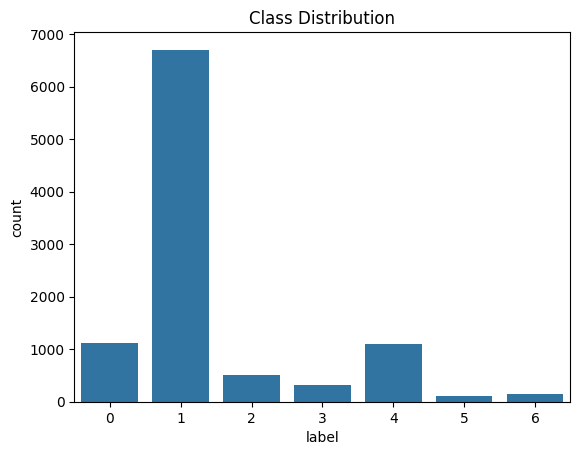

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=df["label"])
plt.title("Class Distribution")
plt.show()


##Define Data Transformation

In [45]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Flip images randomly
    transforms.RandomRotation(10),  # Rotate images randomly
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


##Create Dataset Class

In [46]:
class SkinDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image (for classification)
        img = Image.open(self.image_paths[idx]).convert("RGB")

        # Load the mask (for segmentation)
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Convert to grayscale

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        # Convert mask to tensor
        mask = torch.tensor(np.array(mask), dtype=torch.float32) / 255.0  # Normalize mask to [0,1]

        return img, mask, torch.tensor(self.labels[idx], dtype=torch.long)


# Create datasets
# Create datasets with masks included
train_dataset = SkinDataset(train_imgs, train_masks, train_labels, transform=train_transform)
val_dataset = SkinDataset(val_imgs, val_masks, val_labels, transform=val_test_transform)
test_dataset = SkinDataset(test_imgs, test_masks, test_labels, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



##Visualize Sample Images

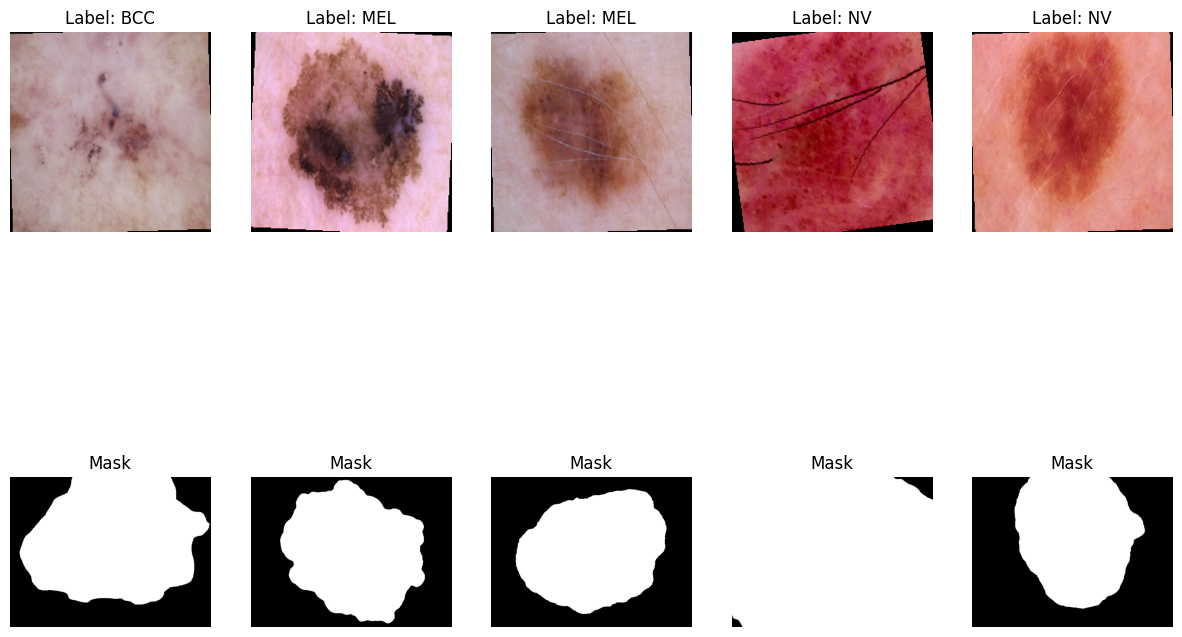

In [47]:
# Function to visualize images with their corresponding masks
def show_sample(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 10))

    for i in range(num_samples):
        img, mask, label = dataset[i]  # Unpack correctly
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

        # Show image
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Label: {class_names[label]}")
        axes[0, i].axis("off")

        # Show corresponding mask
        axes[1, i].imshow(mask, cmap="gray")
        axes[1, i].set_title("Mask")
        axes[1, i].axis("off")

    plt.show()

# Show train samples
show_sample(train_dataset)
